In [1]:
import findspark
findspark.init('/home/ayoubgrm/spark')
#import modules
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, Word2Vec
from pyspark.sql.functions import monotonically_increasing_id

# nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# utilities
import re
import numpy as np
import pandas as pd

# plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#create Spark session
appName = "Sentiment Analysis in Spark"
spark = SparkSession.builder.appName(appName).config("spark.some.config.option", "some-value").getOrCreate()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ayoubgrm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ayoubgrm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#read csv file into dataFrame with automatically inferred schema
schema = StructType([
         StructField('sentiment', IntegerType()),
         StructField('ids', StringType()),
         StructField('date', StringType(), True),
         StructField('flag', StringType(), True),
         StructField('user', StringType()),
         StructField('text', StringType())
         ])
tweets_csv = spark.read.csv('/root/dataset.csv', schema=schema)
tweets_csv.show(truncate=False, n=3)

+---------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|sentiment|ids       |date                        |flag    |user           |text                                                                                                               |
+---------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0        |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0        |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0        |1467810917|Mon Apr 06 22

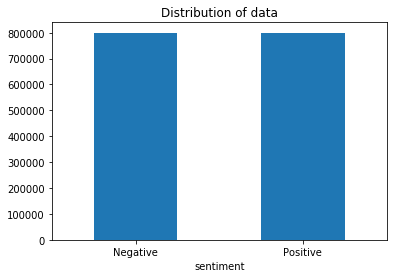

In [3]:
# converting spark dataframe to pandas
dataset = tweets_csv.select('sentiment','text').toPandas()
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [4]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', '>-)':
          'evilgrin', ':(': 'sad', ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', 
          ':-O': 'surprised', ':-*': 'kissing', ':-@': 'shocked', ':-$': 'confused',
          ':-\\': 'annoyed', ':-#': 'mute', '(((H)))': 'hugs', ':-X': 'kissing',
          '`:-)': 'smile', ':^)': 'smile', ':-&': 'confused', '<:-)': 'smile', 
          ':->': 'smile', '(-}{-)': 'kissing', ':-Q': 'smoking','$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':*)': 'smile',
          ':@': 'shocked',':-0': 'yell', ':-----)': 'liar', '%-(': 'confused',
          '(:I': 'egghead', '|-O': 'yawning', ':@)': 'smile', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', '~:0': 'baby', '-@--@-': 'eyeglass',
          ":'-)": 'sadsmile', '{:-)': 'smile', ';)': 'wink', ';-)': 'wink', 
          'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
## Defining set containing all stopwords in english.
stopwordlist = set(stopwords.words('english'))

In [5]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    snowStem = SnowballStemmer("english")
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''           
        for word in tweet.split():            
            # Checking if the word is a stopword.
            if word not in stopwordlist:                
                if len(word)>1:    
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    # Stemming the word.
                    word = snowStem.stem(word)
                    tweetwords += (word+' ')
                    
        processedText.append(tweetwords)
        
    return processedText

In [6]:
processedtext = preprocess(text)
print('Text Preprocessing complete.')

Text Preprocessing complete.


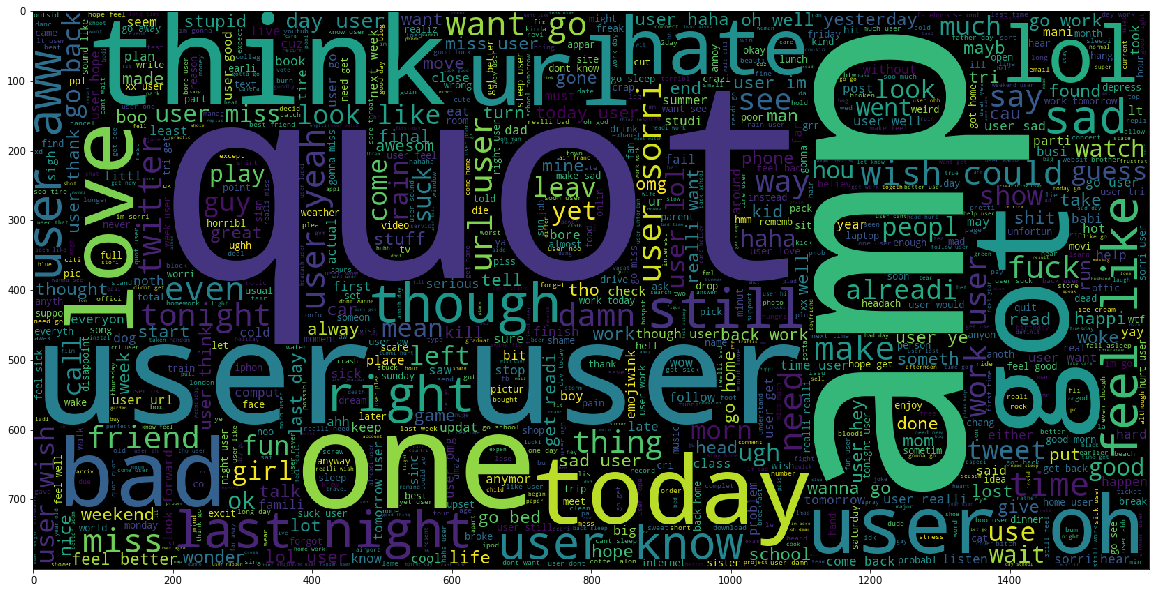

In [7]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_neg))
plt.imshow(wc)

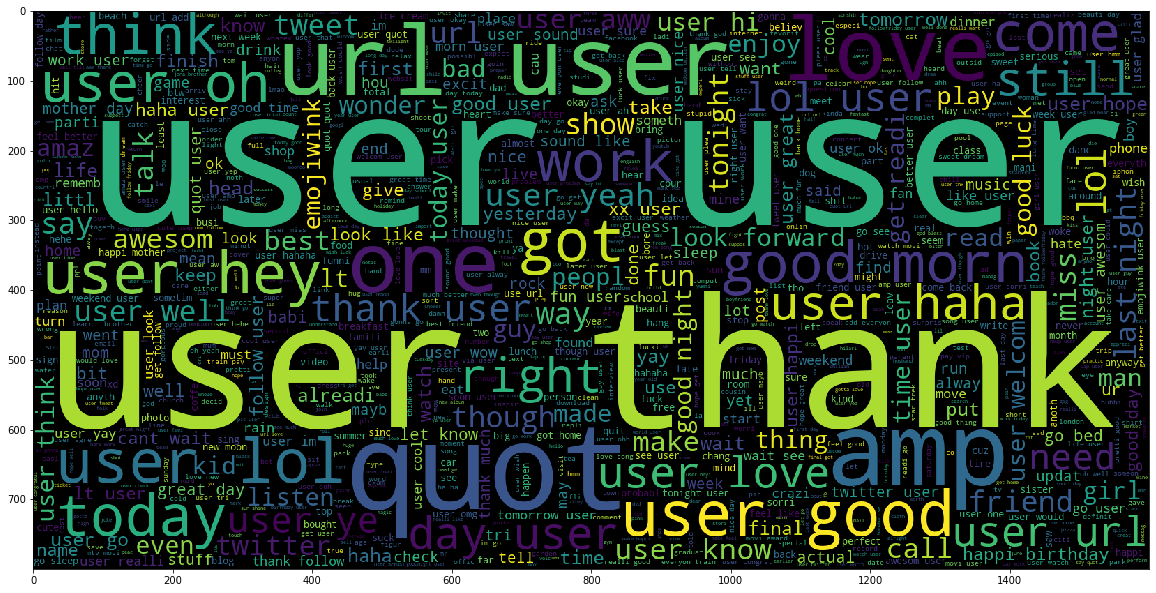

In [8]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [9]:
dataset['text'] = processedtext
pdf = spark.createDataFrame(dataset)
pdf=pdf.filter("text!=''")

In [10]:
#divide data, 70% for training, 30% for testing
dividedData = pdf.randomSplit([0.7, 0.3], seed=12345) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 1119567 ; Testing data rows: 479972


In [11]:
# additional spark dataframe preprocessing
# 1. tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="SentimentWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=False, n=2)

+---------+------------------------------------------------------------------+-----------------------------------------------------------------------------+
|sentiment|text                                                              |SentimentWords                                                               |
+---------+------------------------------------------------------------------+-----------------------------------------------------------------------------+
|0        |00 00 serv foreclosur user thought experi still posit attitud url |[00, 00, serv, foreclosur, user, thought, experi, still, posit, attitud, url]|
|0        |00 03 wreck hungri amp get earli perfect fri night lol night      |[00, 03, wreck, hungri, amp, get, earli, perfect, fri, night, lol, night]    |
+---------+------------------------------------------------------------------+-----------------------------------------------------------------------------+
only showing top 2 rows



In [12]:
# 2. remove stop words
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False, n=2)

+---------+------------------------------------------------------------------+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------+
|sentiment|text                                                              |SentimentWords                                                               |MeaningfulWords                                                              |
+---------+------------------------------------------------------------------+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------+
|0        |00 00 serv foreclosur user thought experi still posit attitud url |[00, 00, serv, foreclosur, user, thought, experi, still, posit, attitud, url]|[00, 00, serv, foreclosur, user, thought, experi, still, posit, attitud, url]|
|0        |00 03 wreck hungri amp get earli perfect fri nigh

In [13]:
# Converting words feature into numerical feature
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrainData = hashTF.transform(SwRemovedTrain).select(
    'sentiment', 'MeaningfulWords', 'features')
numericTrainData.show(truncate=False, n=2)

+---------+-----------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+
|sentiment|MeaningfulWords                                                              |features                                                                                                                        |
+---------+-----------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+
|0        |[00, 00, serv, foreclosur, user, thought, experi, still, posit, attitud, url]|(262144,[5954,21622,31536,78280,107267,132778,141771,142343,166737,201862],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0])           |
|0        |[00, 03, wreck, hungri, amp, get, earli, perfect, fri, night, lol, night]    |(262144,[41809,43950,82103,82438,88

In [14]:
# Train our classifier model using training data
nb = NaiveBayes(labelCol="sentiment", featuresCol="features", 
                        smoothing=1.0, modelType="multinomial")
modelnb = nb.fit(numericTrainData)
print ("Training is done!")

Training is done!


In [15]:
# Train our classifier model using training data
lr = LogisticRegression(labelCol="sentiment", featuresCol="features", 
                        maxIter=10, regParam=0.01)
modellr = lr.fit(numericTrainData)
print ("Training is done!")

Training is done!


In [16]:
# Prepare testing data
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest).select(
    'sentiment', 'MeaningfulWords', 'features')
numericTest.show(truncate=False, n=2)

+---------+------------------------------------+-----------------------------------------------------------------------------+
|sentiment|MeaningfulWords                     |features                                                                     |
+---------+------------------------------------+-----------------------------------------------------------------------------+
|0        |[00, cant, sleep, kind, sick]       |(262144,[79132,166737,234553,243658,261677],[1.0,1.0,1.0,1.0,1.0])           |
|0        |[00, morn, still, awak, want, sleep]|(262144,[31536,110286,155374,166737,190256,234553],[1.0,1.0,1.0,1.0,1.0,1.0])|
+---------+------------------------------------+-----------------------------------------------------------------------------+
only showing top 2 rows



In [17]:
# Predict testing data and calculate the accuracy model
predictionnb = modelnb.transform(numericTest)
predictionFinalnb = predictionnb.select(
    "MeaningfulWords", "prediction", "sentiment")
predictionFinalnb.show(n=5, truncate = False)
correctPrediction = predictionFinalnb.filter(
    predictionFinalnb['prediction'] == predictionFinalnb['sentiment']).count()
totalData = predictionFinalnb.count()
print("correct prediction:", correctPrediction, ", total data:", totalData, 
      ", accuracy:", correctPrediction/totalData)

+-------------------------------------------------------------------------------------------------------+----------+---------+
|MeaningfulWords                                                                                        |prediction|sentiment|
+-------------------------------------------------------------------------------------------------------+----------+---------+
|[00, cant, sleep, kind, sick]                                                                          |0.0       |0        |
|[00, morn, still, awak, want, sleep]                                                                   |0.0       |0        |
|[00, past, bedtim, back, tomorrow, well, hug]                                                          |0.0       |0        |
|[00, still, sit, airport, wait, daughter, flight, come]                                                |0.0       |0        |
|[00, sudden, urg, potato, latk, new, electr, mandolin, smallest, gratter, lard, instead, smaltz, yummi]|0.0   

In [18]:
# Predict testing data and calculate the accuracy model
predictionlr = modellr.transform(numericTest)
predictionFinallr = predictionlr.select(
    "MeaningfulWords", "prediction", "sentiment")
predictionFinallr.show(n=5, truncate = False)
correctPrediction = predictionFinallr.filter(
    predictionFinallr['prediction'] == predictionFinallr['sentiment']).count()
totalData = predictionFinallr.count()
print("correct prediction:", correctPrediction, ", total data:", totalData, 
      ", accuracy:", correctPrediction/totalData)

+-------------------------------------------------------------------------------------------------------+----------+---------+
|MeaningfulWords                                                                                        |prediction|sentiment|
+-------------------------------------------------------------------------------------------------------+----------+---------+
|[00, cant, sleep, kind, sick]                                                                          |0.0       |0        |
|[00, morn, still, awak, want, sleep]                                                                   |0.0       |0        |
|[00, past, bedtim, back, tomorrow, well, hug]                                                          |0.0       |0        |
|[00, still, sit, airport, wait, daughter, flight, come]                                                |0.0       |0        |
|[00, sudden, urg, potato, latk, new, electr, mandolin, smallest, gratter, lard, instead, smaltz, yummi]|0.0   